### model with only recent events , and simple autoregressive features
##### Publication trends forecasting outputs

* Train+val+test Data covers ~1960-2019.
    * Model/features optimized over 1980-2010

* Prediction 5 years (inclusive) in advance

* Temporal split over data

* `y_raw` = Actual amount of publications (normalized out of total pubs that year in pubmed)
* `preds` = model predictions


* SparkBeyond Validation set ~ 2010-2013 , Test set 2014-2019
    * SB Train+val+test Data covers 1980-2019.
    * Raw/context data covers more (and I output that here)
* Prediction 5 years (inclusive) in advance


 * I try redoing time series CV/split here from scratch , to better show predicitons. 
     * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import cross_val_predict,TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNet,ElasticNetCV, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.metrics import PredictionErrorDisplay
from sklearn.pipeline import Pipeline
import numpy as np
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV
import sklearn.metrics as metrics
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
import re
pd.set_option('mode.use_inf_as_na', True)

In [2]:
FILTER_GROUP_SIZES = False#True

DIFF_TARGET = False#True#False#True # set target to diff vs 5 years ago. i.e tougher baseline
DIFF_TARGET_PCT = False#True#False#True
NUM_CV_FOLDS =  5#30 #

DO_RFE_FS = False#False#True

GET_DL_EMBEDS =True#False

CUTOFF_YEAR = 2014

## columns to drop as part of simplifying pipeline:
DROP_FEAT_COLS = ['patent_count', 'patent_frac','patent_yearly_total','pat_div_research',
                  'review_research_ratio_2', 'review_research_diff_2', ]

In [3]:
def plot_var_preds(df,val:str="subthalamus",logScale=False):
#     df.loc[df["variable"].str.contains(val,case=False)][["y_raw","preds"]].plot(title=val)# "y_raw_predicted"
    if logScale:
        df.loc[df["variable"].str.lower()==val.lower()][["y_raw","preds"]].apply(np.log1p).plot(title=val)
    else:
        df.loc[df["variable"].str.lower()==val.lower()][["y_raw","preds"]].plot(title=val)
    
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('r2:', round(r2,3))
    print('MAE (Mean absolute error):', round(mean_absolute_error,3))
    print('Median absolute error:', round(median_absolute_error,3))
#     print('MSE: ', round(mse,3))
    print('RMSE:', round(np.sqrt(mse),3))
    print('explained_variance: ', round(explained_variance,3))    
    try:
        mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
        print('mape:', round(mape,3))
    except:()
    try: 
        mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
        print('mean_squared_log_error:', round(mean_squared_log_error,3))
    except:()

        
def evaluate(model = CatBoostRegressor(cat_features= ["variable"],verbose=False,has_time=True),X = None):
    """
    Assigns results of preictions to df_feat (global var version)
    https://stats.stackexchange.com/questions/495151/cross-validation-for-time-series-what-am-i-doing-wrong
    https://stackoverflow.com/questions/51597507/sklearn-timeseriessplit-error-keyerror-0-1-2-not-in-index
    """
    # train model on training dataset
    i = 0
    tscv = TimeSeriesSplit(NUM_CV_FOLDS) #10) # ORIG - 10
#     df_feat["preds"] = np.NaN # un commented - DAN - new
    for train_index, test_index in tscv.split(X): #df_feat):
        i +=1
#         print(i)
        if i%3==0: print(i)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         X_train, X_test = X.index[train_index], X.index[test_index]#X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         model = CatBoostRegressor(iterations=500,
#                                   cat_features= ["variable"],#[0], #["variable"],
#                           verbose=False,has_time=True)
#         print("fit")
#         model.fit(X_train, y_train)
        model.fit(X_train, y_train,
#                   early_stopping_rounds=10,
#                   eval_set=(X_test, y_test),
                  #plot=(i%3==0),
#                  baseline=X_train["lag5"].values)#pd.concat([X_train["lag5"],X_test["lag5"]]).values)
                  )
#         print("doing pred")
        y_predict = model.predict(X_test)
        assert np.isnan(y_predict).max() == False
#         print("assigning pred")
#         df_feat.loc[test_index,"preds"] =y_predict
        df_feat.iloc[test_index,-1] =y_predict  ##
    print("\n Done")

def truncate(f2, n=1):
    '''Truncates/pads a float f to n decimal places without rounding'''
#     if f.isnumeric():
    try: 
        f = float(f2)
#         s = '{}'.format(f)
#         if 'e' in s or 'E' in s:
#             return '{0:.{1}f}'.format(f, n)
#         i, p, d = s.partition('.')
#         return '.'.join([i, (d+'0'*n)[:n]])
        return(str(round(float(f),2)))
#     else:
    except:
        return f2

#### plot (lagged?) correlation of inputs and target in raw data

In [4]:
df_targets = pd.read_csv("trends_v6.csv.gz",parse_dates=["Year","first","start"],infer_datetime_format=True)

#### NEW! Sort by date!
df_targets = df_targets.sort_values(["Year","variable"])
df_targets["target_5"] = df_targets.groupby("variable")["y_raw"].shift(-5) ## target in 5 years

# df_targets[["Year","variable","y_raw","target_5"]]
df_targets = df_targets.loc[(df_targets["Year"]> df_targets["start"]) & (df_targets["year_num"]>= 1979)]
print(df_targets.shape[0])
df_targets = df_targets.loc[df_targets["year_num"]>= CUTOFF_YEAR ]
print(df_targets.shape[0])

df_targets.drop(columns=[
#                          "pct_diff_lag6",
    "y_pct_bins",
#                          "y_pct_diff","year_num",
                         "lag1","lag2","lag3","lag4",
##ORIG: was commented out! be careful! #                          "diff_lag6","lag6",
#                          "pct_diff_lag5",
#                          "first","start"
            ],errors="ignore",inplace=True)
print(df_targets.shape)
df_targets["lag5_pct_new"] = 100*df_targets["diff_lag5"].div(df_targets["y_raw"])# pct diff vs 5 years ago

df_targets = df_targets.reset_index(drop=True)

df_targets.head(7)

4798
863
(863, 25)


,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,pat_div_research,year_num,y_diff,y_pct_diff,diff_lag5,diff_lag6,pct_diff_lag5,pct_diff_lag6,target_5,lag5_pct_new
0,2014-01-01,BLAST,176.5445,10.7851,169.4097,0.9596,-0.0156,123.0,0.6256,19662.0,...,0.6967,2014,-2.8015,-0.015621,3.7904,1.8885,-0.010889,0.021517,140.1918,2.146994
1,2014-01-01,BRCA1,87.6085,12.0296,-15.5140,-0.1771,0.0083,1.0,0.0051,19662.0,...,0.0114,2014,0.7188,0.008273,-4.4662,1.2362,0.066021,-0.010987,96.4662,-5.097907
2,2014-01-01,BRCA2,55.9998,9.0429,-5.7244,-0.1022,0.0452,0.0,0.0000,19662.0,...,0.0000,2014,2.4221,0.045207,-4.5097,-2.6569,0.031587,0.018600,68.3568,-8.053064
3,2014-01-01,Brodmann area,12.5274,0.5807,7.7985,0.6225,0.1341,0.0,0.0000,19662.0,...,0.0000,2014,1.4814,0.134112,-1.8308,-1.3304,0.036110,0.090127,7.1693,-14.614365
4,2014-01-01,CRISPR,57.8250,9.1259,-1214.8218,-21.0086,1.0146,11.0,0.0559,19662.0,...,0.1902,2014,29.1227,1.014647,53.3808,54.4800,0.328610,0.547894,379.4762,92.314397
5,2014-01-01,Cingulate cortex,158.8734,10.7851,146.8439,0.9243,-0.0222,0.0,0.0000,19662.0,...,0.0000,2014,-3.5991,-0.022152,20.8753,26.7465,0.044436,0.037308,137.4235,13.139582
6,2014-01-01,DNA array,626.2019,51.3539,625.6212,0.9991,-0.1188,21.0,0.1068,19662.0,...,0.0335,2014,-84.3979,-0.118770,-364.6271,-237.0432,0.147796,-0.001652,414.2580,-58.228361


In [5]:
df_targets.columns

Index(['Year', 'variable', 'y_raw', 'reviews', 'research_review_diff',
       'research_review_ratio', 'pct_diff', 'patent_count', 'patent_frac',
       'patent_yearly_total', 'lag5', 'lag6', 'first', 'start',
       'review_research_ratio_2', 'review_research_diff_2', 'pat_div_research',
       'year_num', 'y_diff', 'y_pct_diff', 'diff_lag5', 'diff_lag6',
       'pct_diff_lag5', 'pct_diff_lag6', 'target_5', 'lag5_pct_new'],
      dtype='object')

In [6]:
df_targets["first"] = df_targets["first"].str.split("-",expand=True)[0].astype(int)
df_targets["start"] = pd.to_datetime(df_targets["start"]).dt.year.astype(int)
df_targets["start_sub_first"] = df_targets["start"].sub(df_targets["first"])
df_targets["year_sub_start"] = df_targets["year_num"].sub(df_targets["start"])
df_targets[["target_5","y_raw","reviews","first","start","start_sub_first","year_sub_start"]].corr().round(3)

,target_5,y_raw,reviews,first,start,start_sub_first,year_sub_start
target_5,1.000,0.983,0.924,-0.186,-0.202,-0.098,0.202
y_raw,0.983,1.000,0.917,-0.198,-0.214,-0.100,0.214
reviews,0.924,0.917,1.000,-0.204,-0.224,-0.111,0.223
first,-0.186,-0.198,-0.204,1.000,0.906,0.094,-0.900
start,-0.202,-0.214,-0.224,0.906,1.000,0.506,-0.994
start_sub_first,-0.098,-0.100,-0.111,0.094,0.506,1.000,-0.504
year_sub_start,0.202,0.214,0.223,-0.900,-0.994,-0.504,1.000


In [7]:
display(df_targets.sort_values(["variable","Year"]).head(7))
display(df_targets.sort_values(["variable","Year"]).tail(7))

,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,y_diff,y_pct_diff,diff_lag5,diff_lag6,pct_diff_lag5,pct_diff_lag6,target_5,lag5_pct_new,start_sub_first,year_sub_start
0,2014-01-01,BLAST,176.5445,10.7851,169.4097,0.9596,-0.0156,123.0,0.6256,19662.0,...,-2.8015,-0.015621,3.7904,1.8885,-0.010889,0.021517,140.1918,2.146994,5,64
123,2015-01-01,BLAST,157.8589,11.7698,147.9182,0.9370,-0.1058,122.0,0.6212,19640.0,...,-18.6856,-0.105841,-9.7580,-14.8952,-0.029737,-0.010889,138.0799,-6.181470,5,65
246,2016-01-01,BLAST,155.4674,10.5098,143.6341,0.9239,-0.0151,92.0,0.4699,19578.0,...,-2.3915,-0.015150,-21.3248,-12.1495,0.054740,-0.029737,NaN,-13.716573,5,66
369,2017-01-01,BLAST,147.8053,11.5881,134.9893,0.9133,-0.0493,96.0,0.4536,21165.0,...,-7.6621,-0.049284,-34.0966,-28.9869,0.028902,0.054740,NaN,-23.068591,5,67
492,2018-01-01,BLAST,146.7644,9.8834,134.3545,0.9154,-0.0070,113.0,0.5475,20638.0,...,-1.0409,-0.007042,-32.5816,-35.1375,-0.014051,0.028902,NaN,-22.199934,5,68
615,2019-01-01,BLAST,140.1918,10.2216,128.5506,0.9170,-0.0448,113.0,0.4710,23994.0,...,-6.5726,-0.044783,-36.3527,-39.1542,-0.015621,-0.014051,NaN,-25.930689,5,69
739,2020-01-01,BLAST,138.0799,7.9993,128.8500,0.9332,-0.0151,97.0,0.3748,25883.0,...,-2.1119,-0.015064,-19.7790,-38.4646,-0.105841,-0.015621,NaN,-14.324315,5,70


,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,y_diff,y_pct_diff,diff_lag5,diff_lag6,pct_diff_lag5,pct_diff_lag6,target_5,lag5_pct_new,start_sub_first,year_sub_start
122,2014-01-01,zebra fish,235.4479,22.0681,88.0233,0.3739,-0.0153,0.0,0.0000,19662.0,...,-3.6511,-0.015270,38.4216,46.4562,0.042513,0.074991,287.7659,16.318515,5,61
245,2015-01-01,zebra fish,238.4186,20.7563,79.4464,0.3332,0.0126,0.0,0.0000,19640.0,...,2.9707,0.012617,35.5586,41.3923,0.029609,0.042513,273.3293,14.914357,5,62
368,2016-01-01,zebra fish,264.3801,24.0558,96.9238,0.3666,0.1089,0.0,0.0000,19578.0,...,25.9615,0.108890,36.3338,61.5201,0.124156,0.029609,NaN,13.743016,5,63
491,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,...,-4.1477,-0.015688,35.9295,32.1861,-0.016415,0.124156,NaN,13.806697,5,64
614,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,...,12.8609,0.049421,33.9943,48.7904,0.065965,-0.016415,NaN,12.447870,5,65
738,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,...,14.6726,0.053727,52.3180,48.6669,-0.015270,0.065965,NaN,18.180750,5,66
862,2020-01-01,zebra fish,273.3293,22.3980,125.3426,0.4586,-0.0502,1.0,0.0039,25883.0,...,-14.4366,-0.050168,34.9107,37.8814,0.012617,-0.015270,NaN,12.772396,5,67


In [8]:
if FILTER_GROUP_SIZES:
    print(df_targets.shape[0])
    element_group_sizes = df_targets['variable'].groupby(df_targets['variable']).transform('count')
    df_targets = df_targets[element_group_sizes>1] # was 5, changed for CV results
    df_targets.reset_index(inplace=True,drop=True) # otherwise, error ?? 
    print(df_targets.shape[0])

if DIFF_TARGET_PCT:
    print("DIFF_TARGET_PCT")
    df_targets["target_5"] = 100*df_targets["target_5"].sub(df_targets["lag5"]).div(df_targets["y_raw"]).round(4) # alt, pct change target
#     df_targets["y_raw"] = 100*df_targets["y_raw"].div(df_targets["lag5"]).round(4) # alt, pct change target
elif DIFF_TARGET:
    print("DIFF_TARGET")
    df_targets["target_5"] = df_targets["target_5"].sub(df_targets["lag5"])
#     df_targets["y_raw"] = df_targets["y_raw"].sub(df_targets["lag5"]) # not needed? 
#     df_targets["y_raw"] = df_targets["y_raw"].div(df_targets["lag5"]) # alt, pct change target
if DIFF_TARGET_PCT or DIFF_TARGET:
    print("differencing of target applied")
#     df_targets.dropna(subset=["y_raw"],inplace=True)
    df_targets_orig_full = df_targets.copy() # new, keep copy of full data for getting future preds
    df_targets.dropna(subset=["target_5"],inplace=True) ## originally we dropped - keep these for predictions! 
    df_targets.reset_index(inplace=True,drop=True)
    display(df_targets[["target_5","y_raw"]].describe().round(3))
else:
    df_targets_orig_full = df_targets.copy()

In [9]:
if DIFF_TARGET_PCT:
    print("percent differenced target has some outliers (especially around start of a topic) and some extreme values (11,644)")
    ### extreme growth topics - subthalamus, rnai, MRI, fMRI, carbon nanotubes, perceptron - makes sense
    display(df_targets[df_targets["target_5"]>3000].sort_values(["target_5"],ascending=False).filter(["Year","variable","y_raw","target_5"],axis=1))


In [10]:
df_targets["target_5"]

0      140.1918
1       96.4662
2       68.3568
3        7.1693
4      379.4762
         ...   
858         NaN
859         NaN
860         NaN
861         NaN
862         NaN
Name: target_5, Length: 863, dtype: float64

In [11]:
df_targets["target_5"].corr(df_targets['y_raw'])

0.9831738597609103

## Fig S2- Increasing popularity over time

<Axes: title={'center': 'Increasing popularity over time'}, xlabel='Year', ylabel='Average popularity of all topics'>

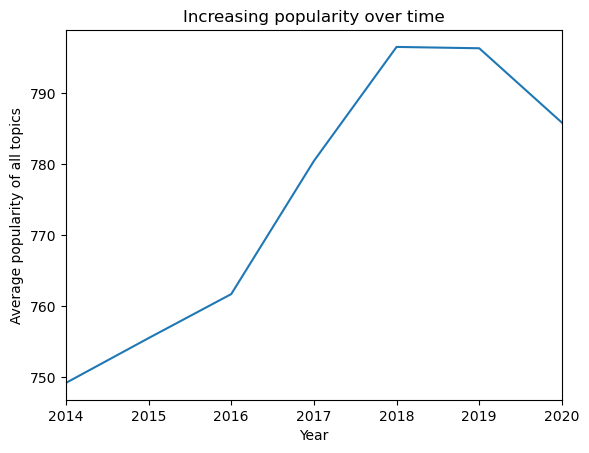

In [12]:
df_targets.groupby("Year")['y_raw'].mean().plot(ylabel="Average popularity of all topics",title="Increasing popularity over time")

In [13]:
# # df_targets.groupby('variable')['y_raw'].apply(lambda x: x.autocorr(lag=1)).mean().round(3)
# df_g = df_targets.groupby(["variable"])
# for i in range(-2,7):#[-1,0,1,2]:
#     print(i,df_g.apply(lambda df2: df2['y_raw'].corr(df2['y_raw'].shift(i))).mean().round(3))

# df_targets.groupby("variable")["y_raw"].shift(-5)
for i in range(-3,9):
    ## assumes data sorted! 
    df_targets["lagged"] = df_targets.groupby("variable")["y_raw"].shift(i).fillna(0) ## fillna 0 greatly changes results!!
    print(i,df_targets['y_raw'].corr(df_targets["lagged"]).round(3))
    df_targets.drop(columns=["lagged"],inplace=True)

-3 0.698
-2 0.803
-1 0.903
0 1.0
1 0.914
2 0.824
3 0.728
4 0.621
5 0.499
6 0.349
7 nan
8 nan


In [14]:
# pd.plotting.autocorrelation_plot(df_targets.groupby('variable')['y_raw'])

In [15]:
print("Correlation with target (y_raw) at same time (not lagged):")
df_targets.corrwith(df_targets["y_raw"],method="spearman").round(2).sort_values()

Correlation with target (y_raw) at same time (not lagged):


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\2343291149.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets["y_raw"],method="spearman").round(2).sort_values()


review_research_diff_2    -1.00
start                     -0.32
first                     -0.28
start_sub_first           -0.23
y_diff                    -0.04
review_research_ratio_2   -0.00
diff_lag5                  0.01
patent_yearly_total        0.01
year_num                   0.01
diff_lag6                  0.05
pct_diff                   0.08
y_pct_diff                 0.08
pct_diff_lag5              0.10
pct_diff_lag6              0.11
lag5_pct_new               0.14
pat_div_research           0.18
year_sub_start             0.27
patent_frac                0.54
patent_count               0.54
research_review_ratio      0.60
research_review_diff       0.91
lag6                       0.94
reviews                    0.95
lag5                       0.96
target_5                   0.96
y_raw                      1.00
dtype: float64

In [16]:
# print("Lagged with target as it will be in 3 years:")
# df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(-3),method="spearman").round(2).sort_values()

In [17]:
print("Lagged with target as it will be in 5 years:")
df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(-5),method="spearman").round(2).sort_values()

Lagged with target as it will be in 5 years:


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\306039777.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(-5),method="spearman").round(2).sort_values()


review_research_diff_2    -0.95
start                     -0.26
first                     -0.22
start_sub_first           -0.21
year_num                  -0.01
patent_yearly_total        0.01
review_research_ratio_2    0.07
y_diff                     0.07
pct_diff                   0.11
y_pct_diff                 0.11
diff_lag5                  0.14
pct_diff_lag5              0.17
lag5_pct_new               0.18
pct_diff_lag6              0.19
diff_lag6                  0.20
year_sub_start             0.24
pat_div_research           0.26
patent_frac                0.55
patent_count               0.55
research_review_ratio      0.56
lag6                       0.85
research_review_diff       0.85
lag5                       0.87
reviews                    0.92
y_raw                      0.96
target_5                   1.00
dtype: float64

In [18]:
print("(reverse) Lagged with target as it was 5 years ago")
df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(5),method="spearman").round(2).sort_values()

(reverse) Lagged with target as it was 5 years ago


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\4003187604.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(5),method="spearman").round(2).sort_values()


review_research_diff_2    -0.96
start                     -0.37
first                     -0.33
y_diff                    -0.29
start_sub_first           -0.26
diff_lag5                 -0.21
diff_lag6                 -0.18
review_research_ratio_2   -0.05
pct_diff_lag5             -0.05
pct_diff                  -0.03
y_pct_diff                -0.03
pct_diff_lag6              0.00
patent_yearly_total        0.00
year_num                   0.00
lag5_pct_new               0.06
pat_div_research           0.09
year_sub_start             0.35
patent_frac                0.50
patent_count               0.50
research_review_ratio      0.62
research_review_diff       0.90
reviews                    0.90
y_raw                      0.96
lag5                       1.00
lag6                       1.00
target_5                    NaN
dtype: float64

##### Corr with lagged, diffed target:

In [19]:
print("Correlation with target diff_lag5 at same time (not lagged):")
df_targets.corrwith(df_targets["diff_lag5"],method="spearman").round(2).sort_values()

Correlation with target diff_lag5 at same time (not lagged):


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\1185706083.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets["diff_lag5"],method="spearman").round(2).sort_values()


year_sub_start            -0.26
lag6                      -0.22
lag5                      -0.18
patent_count              -0.08
patent_frac               -0.08
year_num                  -0.05
pat_div_research          -0.05
research_review_diff      -0.03
patent_yearly_total       -0.03
research_review_ratio     -0.01
review_research_diff_2     0.00
y_raw                      0.01
reviews                    0.07
target_5                   0.14
start_sub_first            0.17
review_research_ratio_2    0.23
first                      0.25
start                      0.26
pct_diff_lag6              0.47
pct_diff_lag5              0.50
pct_diff                   0.62
y_pct_diff                 0.62
y_diff                     0.71
lag5_pct_new               0.81
diff_lag6                  0.97
diff_lag5                  1.00
dtype: float64

In [20]:
print("Lagged with target diff_lag5 as it will be in 5 years:")
df_targets.corrwith(df_targets.groupby("variable")["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()

Lagged with target diff_lag5 as it will be in 5 years:


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\2257841306.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets.groupby("variable")["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()


lag6                      -0.36
lag5                      -0.35
year_sub_start            -0.26
research_review_diff      -0.23
y_raw                     -0.21
reviews                   -0.12
patent_count              -0.11
patent_frac               -0.11
research_review_ratio     -0.11
year_num                  -0.04
pat_div_research          -0.02
target_5                  -0.01
patent_yearly_total        0.04
start_sub_first            0.16
review_research_diff_2     0.22
pct_diff_lag5              0.23
first                      0.27
start                      0.27
pct_diff_lag6              0.28
review_research_ratio_2    0.28
diff_lag6                  0.47
pct_diff                   0.54
y_pct_diff                 0.54
lag5_pct_new               0.54
diff_lag5                  0.55
y_diff                     0.63
dtype: float64

`pct_diff`

In [21]:
print("Lagged with target lag5_pct_new, unlagged")
df_targets.corrwith(df_targets["lag5_pct_new"],method="spearman").round(3).sort_values()

Lagged with target lag5_pct_new, unlagged


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\4072984877.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets["lag5_pct_new"],method="spearman").round(3).sort_values()


year_sub_start            -0.335
review_research_diff_2    -0.132
lag6                      -0.125
lag5                      -0.090
year_num                  -0.088
patent_yearly_total       -0.065
pat_div_research           0.037
patent_count               0.052
patent_frac                0.054
research_review_ratio      0.091
research_review_diff       0.100
y_raw                      0.138
review_research_ratio_2    0.146
reviews                    0.176
target_5                   0.176
start_sub_first            0.203
first                      0.311
start                      0.315
pct_diff_lag6              0.513
pct_diff_lag5              0.540
y_diff                     0.618
pct_diff                   0.725
y_pct_diff                 0.725
diff_lag6                  0.794
diff_lag5                  0.809
lag5_pct_new               1.000
dtype: float64

In [22]:
print("Lagged with target pct_diff (vs 5 y ago) as it will be in 5 years:")
df_targets.corrwith(df_targets.groupby("variable")["lag5_pct_new"].shift(-5),method="spearman").round(2).sort_values()

Lagged with target pct_diff (vs 5 y ago) as it will be in 5 years:


C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\4240780205.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets.groupby("variable")["lag5_pct_new"].shift(-5),method="spearman").round(2).sort_values()


year_sub_start            -0.29
lag6                      -0.14
lag5                      -0.12
year_num                  -0.08
review_research_diff_2    -0.05
research_review_diff       0.01
y_raw                      0.06
research_review_ratio      0.07
patent_yearly_total        0.08
patent_count               0.10
patent_frac                0.10
reviews                    0.11
pat_div_research           0.13
start_sub_first            0.17
review_research_ratio_2    0.22
first                      0.28
start                      0.28
target_5                   0.29
pct_diff_lag5              0.35
pct_diff_lag6              0.35
diff_lag6                  0.52
y_diff                     0.54
diff_lag5                  0.55
pct_diff                   0.57
y_pct_diff                 0.57
lag5_pct_new               0.70
dtype: float64

In [23]:
df_targets.corrwith(df_targets["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()

C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\1339698907.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()


review_research_diff_2    -0.08
year_num                  -0.05
start_sub_first           -0.04
y_diff                    -0.03
patent_yearly_total       -0.03
first                     -0.01
start                     -0.01
pat_div_research           0.00
y_pct_diff                 0.01
pct_diff                   0.01
diff_lag5                  0.02
year_sub_start             0.02
diff_lag6                  0.02
research_review_ratio      0.04
target_5                   0.04
lag5_pct_new               0.05
lag6                       0.06
patent_count               0.06
pct_diff_lag5              0.06
lag5                       0.07
patent_frac                0.07
y_raw                      0.08
research_review_diff       0.08
review_research_ratio_2    0.09
pct_diff_lag6              0.10
reviews                    0.11
dtype: float64

In [24]:
df_targets.corrwith(df_targets.groupby("variable")["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()

C:\Users\ddofe\AppData\Local\Temp\ipykernel_1820\2159289963.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_targets.corrwith(df_targets.groupby("variable")["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()


lag6                      -0.36
lag5                      -0.35
year_sub_start            -0.26
research_review_diff      -0.23
y_raw                     -0.21
reviews                   -0.12
patent_count              -0.11
patent_frac               -0.11
research_review_ratio     -0.11
year_num                  -0.04
pat_div_research          -0.02
target_5                  -0.01
patent_yearly_total        0.04
start_sub_first            0.16
review_research_diff_2     0.22
pct_diff_lag5              0.23
first                      0.27
start                      0.27
pct_diff_lag6              0.28
review_research_ratio_2    0.28
diff_lag6                  0.47
pct_diff                   0.54
y_pct_diff                 0.54
lag5_pct_new               0.54
diff_lag5                  0.55
y_diff                     0.63
dtype: float64

### Baseline model - lag raw
* baseline model of input features, lag 5

In [25]:
# df_targets["target_5"] = df_targets.groupby("variable")["y_raw"].shift(-2)
df_targets[["Year","variable","y_raw","target_5"]]

,Year,variable,y_raw,target_5
0,2014-01-01,BLAST,176.5445,140.1918
1,2014-01-01,BRCA1,87.6085,96.4662
2,2014-01-01,BRCA2,55.9998,68.3568
3,2014-01-01,Brodmann area,12.5274,7.1693
4,2014-01-01,CRISPR,57.8250,379.4762
...,...,...,...,...
858,2020-01-01,vaccine,1641.1449,NaN
859,2020-01-01,viral therapy,1272.5626,NaN
860,2020-01-01,vitamin C,186.8140,NaN
861,2020-01-01,vitamin D,351.0454,NaN


In [26]:
# df_lagged = df_targets.dropna(subset=["target_5"],axis=0).copy()

df_lagged = df_targets.filter(['variable', 'reviews',
                              'patent_count', 'patent_frac','patent_yearly_total',
                               'year_num', 
"y_raw",                              ## ADdded: Here it is 5 befre?  NEW
                              "lag5_pct_new","pct_diff_lag5", ## also new - check not leak? 
                              'research_review_diff',
       'research_review_ratio', 'pct_diff', 
                              'review_research_ratio_2',
       'review_research_diff_2', 'pat_div_research',
        'y_diff','y_pct_diff', 
        'target_5']).reset_index(drop=True)

num_cols = list(df_lagged.select_dtypes("number").drop(columns=['target_5',
#                                                                 "y_raw", ### Keeep? NEW
                                                                "y_raw_predicted","preds"],errors="ignore").columns)
df_lagged = df_lagged.filter(["variable","target_5"]+num_cols,axis=1)
mask = ~df_lagged["target_5"].isna()
# X = df_lagged[["variable"]+num_cols]#.copy() 
# y = df_lagged["target_5"] ## target in 5Y

X = df_lagged[mask][["variable"]+num_cols]#.copy() 
y = df_lagged[mask]["target_5"] ## target in 5Y
assert (X.shape[0]>100)
assert (y.isna().sum()==0)

In [27]:
%%time
if GET_DL_EMBEDS:
    print("Pre embed non linear model (with all numeric features)")
    i = 0
    tscv = TimeSeriesSplit(NUM_CV_FOLDS)
    df_lagged["preds"] = np.NaN
    X2 = X.select_dtypes("number")
    for train_index, test_index in tscv.split(X): #df_feat):
        i +=1
        if (i%4)==0: print(i)
        X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = CatBoostRegressor(iterations=100,
    #                               cat_features= ["variable"],
                          verbose=False,has_time=True)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        assert np.isnan(y_predict).max() == False
    #         df_feat.loc[test_index,"preds"] =y_predict
        df_lagged.iloc[test_index,-1] =y_predict

    y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
    y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]
    regression_results(y_true_base, y_pred_base)

Pre embed non linear model (with all numeric features)
4
r2: 0.921
MAE (Mean absolute error): 160.95
Median absolute error: 68.981
RMSE: 420.377
explained_variance:  0.922
mape: 1.9
CPU times: total: 516 ms
Wall time: 963 ms


In [28]:
## frequently crashes when running on cpu, randomly. # but -  it improves model perf!! 
if GET_DL_EMBEDS:
    import gc
    import torch
    gc.collect()
    torch.cuda.empty_cache()
    from sentence_transformers import SentenceTransformer
    torch.cuda.empty_cache()
    model = SentenceTransformer('all-MiniLM-L12-v2',device="cpu") # same res with L6
    #Our sentences we like to encode
    sentences = list(df_lagged["variable"].unique())
    print(len(sentences))

    #Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences,batch_size=128,show_progress_bar=True,)#.to("cpu")

    df_embed_feats = pd.DataFrame(index=sentences, data=embeddings)
    print(df_embed_feats.shape)
    df_embed_feats.columns = ["embed_"+str(i) for i in df_embed_feats.columns]
    df_embed_feats.to_parquet("var_text_embeddings.parquet")
    
#     ### OPT - truncate size of dims
#     ### Has SAME Results as using all embeds
    from sklearn.decomposition import PCA
    pca = PCA(64)#64)
    pca.fit(df_embed_feats)
    print(pca.explained_variance_ratio_[0:2])
    print(sum(pca.explained_variance_ratio_))
    print(len(pca.singular_values_))
    df_embed_feats = pd.DataFrame(pca.transform(df_embed_feats),index=df_embed_feats.index)
    df_embed_feats.columns = ["embed_"+str(i) for i in df_embed_feats.columns]

    print(X.shape)
    X = X.join(df_embed_feats,on="variable",how="left")
    df_lagged = df_lagged.join(df_embed_feats,on="variable",how="left")
    ### our prediction code assumes "pred" to be the last column - resort this - hack
    temp = df_lagged["preds"]
    df_lagged.drop(columns=["preds"],inplace=True)
    df_lagged["preds"] = temp
    print(X.shape)

124


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(124, 384)
[0.07240041 0.04808656]
0.8850201023742557
64
(246, 17)
(246, 81)


In [42]:
print("Naive lag model")
i = 0
tscv = TimeSeriesSplit(NUM_CV_FOLDS)#10)
df_lagged["preds"] = np.NaN
X2 = X[["y_raw"]].copy()
for train_index, test_index in tscv.split(X2): #df_feat):
    i +=1
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = RidgeCV()#LinearRegression() ## better results
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
#         df_feat.loc[test_index,"preds"] =y_predict
    df_lagged.iloc[test_index,-1] =y_predict
    
print("Baseline Lag model")
y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]

assert y_pred_base.shape[0]>4
regression_results(y_true_base, y_pred_base)

Naive lag model
Baseline Lag model
r2: 0.961
MAE (Mean absolute error): 154.44
Median absolute error: 62.772
RMSE: 296.767
explained_variance:  0.961
mape: 0.899
mean_squared_log_error: 0.432


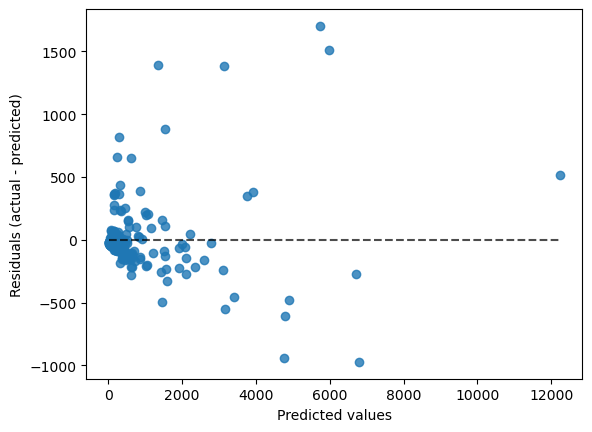

In [44]:
display = PredictionErrorDisplay(y_true=y_true_base, y_pred=y_pred_base)
display.plot()

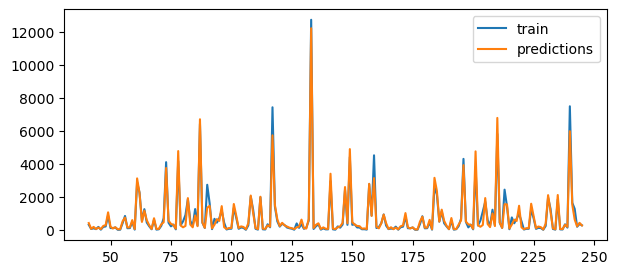

In [46]:
# Plot
### https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
# ==============================================================================
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 3))
# data_train['y'].plot(ax=ax, label='train')
# data_test['y'].plot(ax=ax, label='test')
# predictions.plot(ax=ax, label='predictions')
df_lagged.dropna(subset=["preds"])["target_5"].plot(ax=ax, label='train')
y_pred_base.plot(ax=ax, label='predictions')
ax.legend();

In [30]:
%%time
# ## TMP copy of df, since function expects to put results in df_feat, which doesn't exist yet
# df_feat = df_lagged.copy()
# # df_feat.drop(columns=["preds"],errors="ignore",inplace=True)
# evaluate(model = CatBoostRegressor(verbose=False,has_time=True),X = X[["y_raw"]])

# print("Baseline Lag model")
# y_true_base = df_feat.dropna(subset=["preds"],axis=0)["target_5"]
# y_pred_base = df_feat.dropna(subset=["preds"])["preds"]

# regression_results(y_true_base, y_pred_base)

i = 0
tscv = TimeSeriesSplit(NUM_CV_FOLDS)#10)
df_lagged["preds"] = np.NaN
X2 = X.select_dtypes(["number"]).fillna(X.select_dtypes(["number"]).mean()).copy()
for train_index, test_index in tscv.split(X2): #df_feat):
    i +=1
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = RidgeCV()#LinearRegression() ## better results
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
#         df_feat.loc[test_index,"preds"] =y_predict
    df_lagged.iloc[test_index,-1] =y_predict
    
print("Linear model")
y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]

assert y_pred_base.shape[0]>4
regression_results(y_true_base, y_pred_base)

Linear model
r2: 0.974
MAE (Mean absolute error): 120.086
Median absolute error: 48.727
RMSE: 242.202
explained_variance:  0.974
mape: 1.883
CPU times: total: 0 ns
Wall time: 54.8 ms


In [31]:
%%time
print("linear model with all features")
i = 0
tscv = TimeSeriesSplit(NUM_CV_FOLDS)#10)
df_lagged["preds"] = np.NaN
X2 = X.select_dtypes("number").dropna(how="any",axis=1)
for train_index, test_index in tscv.split(X): 
    i +=1
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     model = LinearRegression()
    model = RidgeCV()
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    assert np.isnan(y_predict).max() == False
#         df_feat.loc[test_index,"preds"] =y_predict
    df_lagged.iloc[test_index,-1] =y_predict

y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]
regression_results(y_true_base, y_pred_base)

linear model with all features
r2: 0.974
MAE (Mean absolute error): 120.042
Median absolute error: 48.626
RMSE: 242.001
explained_variance:  0.974
mape: 1.888
CPU times: total: 0 ns
Wall time: 37 ms


In [32]:
%%time
if not GET_DL_EMBEDS:
    print("non linear model (with all features)")
    i = 0
    tscv = TimeSeriesSplit(NUM_CV_FOLDS)
    df_lagged["preds"] = np.NaN
    X2 = X.copy()
    # X2 = X.select_dtypes("number").copy()
    for train_index, test_index in tscv.split(X2): #df_feat):
        i +=1
        if (i%3)==0: print(i)
        X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = CatBoostRegressor(#iterations=300,
                                  cat_features= ["variable"],
                          verbose=False,has_time=True)
        model.fit(X_train, y_train,
                  )
        y_predict = model.predict(X_test)
        assert np.isnan(y_predict).max() == False
    #         df_feat.loc[test_index,"preds"] =y_predict
        df_lagged.iloc[test_index,-1] =y_predict

    y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
    y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]
    regression_results(y_true_base, y_pred_base)

# ## pct change, with categorical, AND with DL, 30 folds: 
# r2: 0.438
# MAE (Mean absolute error): 47.867
# Median absolute error: 14.904
# RMSE: 217.729
# explained_variance:  0.438
# mape: 1.796

## this model does better when not using DL embeddings

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
%%time
if GET_DL_EMBEDS:
    print("non linear model (with numeric features)")
    i = 0
    tscv = TimeSeriesSplit(NUM_CV_FOLDS)
    df_lagged["preds"] = np.NaN
    X2 = X.select_dtypes("number").copy()
    for train_index, test_index in tscv.split(X2): #df_feat):
        i +=1
        if (i%3)==0: print(i)
        X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = CatBoostRegressor(verbose=False,has_time=True)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        assert np.isnan(y_predict).max() == False
    #         df_feat.loc[test_index,"preds"] =y_predict
        df_lagged.iloc[test_index,-1] =y_predict

    y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
    y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]
    regression_results(y_true_base, y_pred_base)


# # pct change, without categorical, with DL, 30 folds: 
# r2: 0.447
# MAE (Mean absolute error): 48.291
# Median absolute error: 15.114
# RMSE: 216.043
# explained_variance:  0.447
# mape: 1.721

non linear model (with numeric features)
3
r2: 0.874
MAE (Mean absolute error): 199.351
Median absolute error: 64.008
RMSE: 531.041
explained_variance:  0.876
mape: 3.793
CPU times: total: 4.94 s
Wall time: 5.48 s


In [34]:
# list(X.select_dtypes("number").columns[-64:])
# [X.columns.get_loc(c) for c in X.columns if ((c in X) and "embed" in c)]

In [35]:
# # list(df_embed_feats[[c for c in X.columns if "embed" in c]].values)
# X["embed"] = list(X[[c for c in X.columns if "embed" in c]].values) # has error wit hembed feat

# X["embed"]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


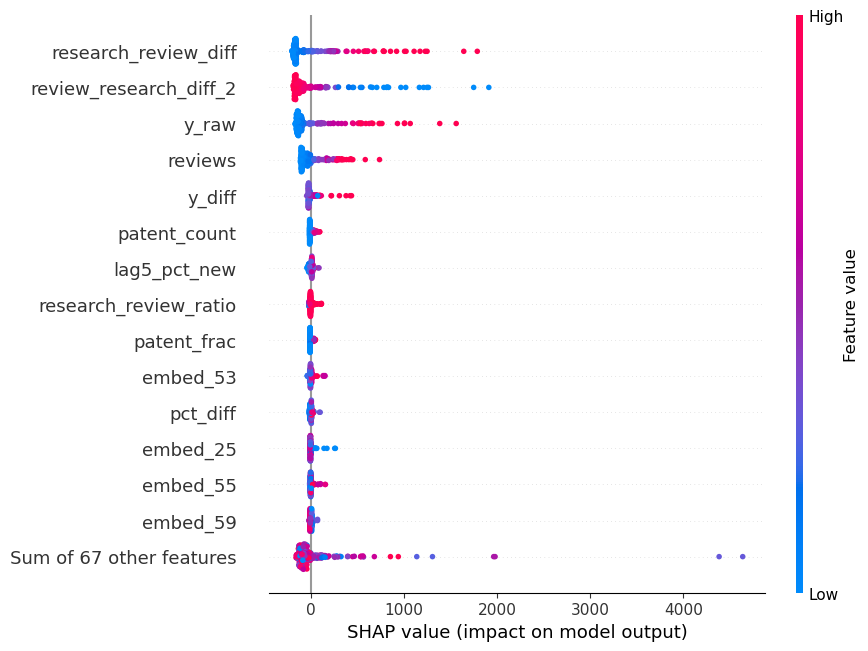

In [38]:
# !pip install -U tensorflow==2.10  ## needed to avoid compat error .. ? 
import shap

# X2 = X.select_dtypes("number").copy()
X2 = X.copy()
model = CatBoostRegressor(#iterations=500,
                          cat_features= ["variable"#,"embed"
                                        ],
                      verbose=False,has_time=True,
#      embedding_features=["embed"],
#                       embedding_features=[X2.columns.get_loc(c) for c in X2.columns if ((c in X2) and "embed" in c)]
                            )
model.fit(X2,y)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X2)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values,max_display=15,)
# shap.plots.bar(shap_values)

In [39]:
print("fillna Baseline Lag model")
y_true_base = df_lagged["target_5"].fillna(0)
y_pred_base = df_lagged["y_raw"].fillna(0)

regression_results(y_true_base, y_pred_base)

fillna Baseline Lag model
r2: -1.622
MAE (Mean absolute error): 599.475
Median absolute error: 142.74
RMSE: 1503.797
explained_variance:  -1.274
mape: 2.5250297985026166e+18
mean_squared_log_error: 22.751


In [40]:
print("Baseline Single feature model (vs +5Y)")
### new
y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
y_pred_base = df_lagged.dropna(subset=["preds"])["y_raw"]

regression_results(y_true_base, y_pred_base)

Baseline Single feature model (vs +5Y)
r2: 0.959
MAE (Mean absolute error): 142.688
Median absolute error: 51.718
RMSE: 301.421
explained_variance:  0.96
mape: 0.268
mean_squared_log_error: 0.18


* Baseline lag model with just raw variables (res, pat, reviews + year, variable):
```
Baseline Lag model
r2:  0.787
MAE (Mean absolute error): 302.0646
Median absolute error): 171.7013
RMSE:  546.6826
explained_variance:  0.7893
mean_squared_log_error:  2.3782
```


* Baseline lag model with ~all variables (including engineered) gets results closer to SB bt still inferior:
```
Baseline+ engineered Lag model
r2:  0.913
MAE (Mean absolute error): 162.549
Median absolute error): 71.4473
RMSE:  350.1588
explained_variance:  0.9132
```

SB model (copied from below):
```
r2:  0.965
MAE (Mean absolute error): 102.1891
Median absolute error): 32.6761
RMSE:  254.8408
explained_variance:  0.9652
```

### Get future predictions

###### ful data for future predictions
* Note, there's some "bad rows" from early dates - likely due to wrong annotations. Could drop from full data, ignore for now

In [ ]:
df_future_targets = df_targets_orig_full.filter(df_lagged.columns,axis=1)

if GET_DL_EMBEDS:
    df_future_targets = df_future_targets.join(df_embed_feats,on="variable",how="left")

df_future_targets = df_future_targets.loc[df_future_targets["target_5"].isna()]
display(df_future_targets)
df_future_targets = df_future_targets.loc[df_future_targets["year_num"]>2012].drop(columns=["target_5"],errors="ignore").drop_duplicates()
print(df_future_targets.shape[0])

In [ ]:
df_future_targets.columns

In [ ]:
y.describe()

In [ ]:
# X[X["year_num"]>2005]  # ~1200 rows
y.tail(1000).describe().round(1)

In [ ]:
VIEW_COLS_LST =['variable', 'pred', 'y_raw',"pred_year", 'year_num',
                'reviews', 'patent_count',
       'pct_diff_lag5', 'y_diff', 'y_pct_diff']
model = CatBoostRegressor(#iterations=700,
                          cat_features= ["variable"],
                      verbose=False,has_time=True)
model.fit(X, y)#,baseline=X_train["y_raw"]
df_future_targets["pred_year"] = df_future_targets["year_num"]+5
df_future_targets = df_future_targets.loc[df_future_targets["pred_year"]>=2019].reset_index(drop=True)
df_future_targets["pred"] = model.predict(df_future_targets.drop(columns=["pred","pred_year"],errors="ignore")).round(2)
df_future_targets.sort_values(["pred","variable"],inplace=True)

df_res = df_future_targets.loc[df_future_targets["pred_year"].between(2022,2022)][VIEW_COLS_LST].round(2)
# display(df_future_targets[VIEW_COLS_LST].round(2).drop_duplicates(subset=["variable"],keep="first").head(10))
# display(df_future_targets[VIEW_COLS_LST].round(2).tail(15))

display(df_res.drop_duplicates(subset=["variable"],keep="first").head(15))
display(df_res.tail(15))

* declining (predicted, and actual) pop terms:
https://esperr.github.io/pubmed-by-year/?q1=pituitary%20gland&q2=serotonin&q3=eugenics&q4=Medulla%20oblongata&q5=influenza&q6=DNA%20array&q7=junk%20dna&q8=subthalamus&q9=neuropeptide&startyear=2000&endyear=2022


* PRedicted to increase terms:

`https://esperr.github.io/pubmed-by-year/?q1=Mononucleosis&q2=Drug%20repurposing&q3=machine%20learning&q4=Synthetic%20Biology&q5=NGS&q6=cumin&q7=nanopore&q8=cannabidiol&q9=graph%20neural%20network&q10=metabolome&q11=carbon%20nanotubes&q12=illumina&q13=miRNA&q14=biosimilar&q15=connectome&q16=lncRNA&q17=natural%20medicine&q18=CRISPR&q19=lithium&startyear=2000`

In [ ]:
df_res.drop_duplicates(subset=["variable"],keep="first").head(15)["variable"].unique()

In [ ]:
print("Increasing (predicted) popularity:")
display(df_res.drop_duplicates(subset=["variable"],keep="last").tail(20))
df_res.drop_duplicates(subset=["variable"],keep="last").tail(20)["variable"].unique()

### (Predicted) Non trivial flips of direction
* cases where prediction is in a different direction than 5Y, 1 Y momentum
    * Many are ~ 0 change (i.e. nearly stable , but can shift a bit up or down)
    
https://esperr.github.io/pubmed-by-year/?q1=Norepinephrine&q2=HMM&q3=zebra%20fish&q4=savant&q5=genetic%20algorithm&q6=carbon%20dating&q7=ancient%20viruses&q8=viral%20therapy&q9=amygdala&q10=eugenics&q11=carbon%20nanotubes&q12=cerebellum&q13=hippocampus&q14=MRI&q15=Mononucleosis&q16=neocortex&q17=antibiotic&startyear=2005

In [ ]:
flip_trend_mask = (np.sign(df_res["pct_diff_lag5"]) != np.sign(df_res["pred"]))\
          & (np.sign(df_res["y_pct_diff"]) != np.sign(df_res["pred"]))
print(df_res.loc[flip_trend_mask]["variable"].unique())
df_res.loc[(flip_trend_mask) & (df_res['y_pct_diff'].abs().round(2)> 0)][['variable', 'pred', 'y_raw',"pred_year", 'y_diff', 'y_pct_diff']]#["variable"].unique()


In [ ]:
df_res.drop_duplicates(subset=["variable"],keep="first").head(9)["variable"].unique()

## actual search res (terms all declined):
## https://esperr.github.io/pubmed-by-year/?q1=eugenics&q2=somatosensory%20cortex&q3=junk%20dna&q4=influenza&q5=soy%20milk&q6=paleocortex&q7=ancient%20dna&startyear=1990

In [ ]:
df_future_targets.loc[df_future_targets.reset_index().groupby(['variable'])['pred'].idxmax()].sort_values("pred")

### Features data

* change to after start

In [ ]:
df_feat = pd.read_csv("trends_demo_rev22_predicted.tsv.gz",sep="\t",parse_dates=["Year","first","start"])

df_feat = df_feat.loc[df_feat["Year"]> df_feat["start"]]
df_feat = df_feat.loc[(df_feat["Year"]> df_feat["start"]) & (df_feat["year_num"]>= 1979) ].reset_index(drop=True)

df_feat.sort_values("Year",inplace=True,ascending=True) ## sort by year , not topic
df_feat["variable"] = df_feat["variable"].str.strip('"')

df = df_feat.filter(['Year', 'variable', 'y_raw',"preds",'y_raw_predicted',  'first', 'start', 'year_num',
               "pct_diff_lag6"],axis=1).set_index("Year").copy()

df.rename(columns={"y_raw_predicted":"preds"},inplace=True)
df

In [ ]:
if GET_DL_EMBEDS:
    df_embed_feats = pd.read_parquet("var_text_embeddings.parquet")
    print(df_embed_feats.shape)
#     df_embed_feats.columns = ["embed_"+str(i) for i in df_embed_feats.columns]

#     ### OPT - truncate size of dims
#     ### Has SAME Results as using all embeds
    from sklearn.decomposition import PCA
    pca = PCA(64)
    pca.fit(df_embed_feats)
    print(pca.explained_variance_ratio_[0:2])
    print(sum(pca.explained_variance_ratio_))
    print(len(pca.singular_values_))
    df_embed_feats = pd.DataFrame(pca.transform(df_embed_feats),index=df_embed_feats.index)
    df_embed_feats.columns = ["embed_"+str(i) for i in df_embed_feats.columns]

    print(df_feat.shape)
#     X = X.join(df_embed_feats,on="variable",how="left")
#     df_lagged = df_lagged.join(df_embed_feats,on="variable",how="left")
    df_feat = df_feat.join(df_embed_feats,on="variable",how="left")
    print(df_feat.shape)

In [ ]:
df_feat = df_feat.filter(list(df_feat.select_dtypes(["number"]).columns)+["variable"],axis=1)
df_feat = df_feat.T.drop_duplicates().T.infer_objects() ## drop some duplicate cols

# changed:
df_feat["variable"] = df_feat["variable"].astype("category")
df_feat.reset_index(inplace=True,drop=True)


### make prettier column names from SB features
# truncate long numbers in the column names
# df_feat.columns = df_feat.columns.str.replace(r'\d+\.\d{3}\d*', lambda x: '{:.3f}'.format(float(x.group(0))))
df_feat.columns = df_feat.columns.str.replace(r'\d+\.\d{3}\d*', lambda x: '{:.2f}'.format(float(x.group(0))),regex=True) # changed top .2f res

# df_feat.columns = df_feat.columns.str.replace("and 5 years before","before")
df_feat.columns = df_feat.columns.str.replace("between 11 years and 5 years before","between 11 and 5 years before")
df_feat.columns = df_feat.columns.str.replace("between 11 years and 5 years before","between 20 and 5 years before")
df_feat.columns = df_feat.columns.str.replace("trends_context_v5.csv.gz_","trends-")
df_feat.columns = df_feat.columns.str.replace("Year","date")
df_feat.columns = df_feat.columns.str.replace("(?<!^)variable","topic",regex=True)

df_feat.columns = df_feat.columns.str.replace("_from_date_","")
df_feat.columns = df_feat.columns.str.replace("_with_5_years_offset","")
## drop y_raw_predicted ? 

display(df_feat.head(7))

In [ ]:
# df.groupby(["variable"])["y_raw"].transform("pct_change").reset_index()#.describe()
### highlky variable topics : 
# df.groupby(["variable"])["pct_diff_lag6"].std().sort_values(ascending=False)

In [ ]:
df["variable"].unique()

In [ ]:
df["variable"].value_counts().sort_values()

In [ ]:
df["variable"].value_counts().sort_values().hist()

##### Check variables with high/low errors
* +- those with few cases?
* I make a pseudo % error target.

In [ ]:
df["error_pct"] = 100*(df["y_raw"].sub(df["preds"])).div(df["y_raw"]).round(3).replace([np.inf, -np.inf], np.nan)
display(df["error_pct"].describe().round(1)) # .dropna(axis=0)

### We see the highest errors in the cases with very short time-frames

In [ ]:
df.groupby(["variable"])["error_pct"].median().sort_values()

### REMOVE variables with too few cases
* this will improve modelling results! 

In [ ]:
if FILTER_GROUP_SIZES:
    print(df_feat.shape[0])
    element_group_sizes = df_feat['variable'].groupby(df_feat['variable']).transform('count')
    df_feat = df_feat[element_group_sizes>6]
    df_feat.reset_index(inplace=True,drop=True) # otherwise, error ?? 
    print(df_feat.shape[0])

In [ ]:
display(df_feat["y_raw"].describe().round(2))

#### opt: make different, touger differenced target

In [ ]:
# if DIFF_TARGET:
#     df_feat["y_raw"] = df_feat["y_raw"].sub(df_feat["lag5"])
# #     df_feat["y_raw"] = df_feat["y_raw"].div(df_feat["lag5"]) # alt, pct change target
#     df_feat.dropna(subset=["y_raw"],inplace=True,axis=0)
#     df_feat.reset_index(inplace=True,drop=True)
#     display(df_feat["y_raw"].describe().round(2))

if DIFF_TARGET_PCT:
    df_feat["y_raw"] = 100*df_feat["y_raw"].sub(df_feat["lag5"]).div(df_feat["lag5"]).round(4) # alt, pct change target
    ### note outliers.. 
elif DIFF_TARGET:
    df_feat["y_raw"] = df_feat["y_raw"].sub(df_feat["lag5"])
#     df_feat["y_raw"] = df_feat["y_raw"].div(df_feat["lag5"]) # alt, pct change target
if DIFF_TARGET_PCT or DIFF_TARGET:
    df_feat.dropna(subset=["y_raw"],inplace=True)
    df_feat.reset_index(inplace=True,drop=True)
    display(df_feat["y_raw"].describe().round(2))

### temporal CV

* https://stackoverflow.com/questions/41753795/sklearn-timeseriessplit-cross-val-predict-only-works-for-partitions

In [ ]:
num_cols = list(df_feat.select_dtypes("number").drop(columns=["y_raw","y_raw_predicted","preds"],errors="ignore").columns)

# X = df_feat.filter(["variable"]+num_cols,axis=1).copy()

X = df_feat[["variable"]+num_cols]#.copy() # try values ? 
# X = X.fillna(0)
y = df_feat["y_raw"]#.copy()#.values

# ## https://stackoverflow.com/questions/41753795/sklearn-timeseriessplit-cross-val-predict-only-works-for-partitions
# preds = cross_val_predict(clf,X.fillna(0),y,cv=cv.split(df_feat))

In [ ]:
print(len(X))
X

#### RFECV FS - check overfitting
* We see that the best model uses just the features we had engineered in advance (lags and basic transformations).
* since we made those in advance and had such a model, using them is not overly problematic. 

In [ ]:
%%time
if DO_RFE_FS:
    sfs = RFECV(ElasticNet(l1_ratio=0.35), min_features_to_select=7,step=0.05,
                n_jobs=-1,cv=TimeSeriesSplit())
    sfs.fit(X.select_dtypes("number"), y)
    print(len(sfs.get_feature_names_out()))
    list(sfs.get_feature_names_out())

if DO_RFE_FS:
    print(len(sfs.get_feature_names_out()))
    list(sfs.get_feature_names_out())

    # X2 = sfs.transform(X.select_dtypes("number"))
    X2 = X.filter(list(set(["variable","year_num","lag5"]+list(sfs.get_feature_names_out()))),axis=1).copy()
    X2
else: 
    X2 = X.copy()

In [ ]:
### keep subset feats!
print("Filter feats")
X = X2
print(X.shape[1])

In [ ]:
# cv = TimeSeriesSplit(n_splits=NUM_CV_FOLDS)
# clf = Ridge(alpha=0.5) # HistGradientBoostingRegressor
# clf =HistGradientBoostingRegressor(categorical_features=categorical_mask)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

In [ ]:
%%time 
print("CB full model")
# tscv = TimeSeriesSplit(NUM_CV_FOLDS)
df_feat["preds"] = np.NaN

evaluate(X=X)

display(df_feat.filter(["year_num","y_raw","preds","y_raw_predicted","variable"],axis=1).dropna(axis=0))
print(df_feat.filter(["year_num","y_raw","preds","y_raw_predicted"],axis=1).corrwith(df_feat["y_raw"]).round(3).sort_values())

y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

In [ ]:
print("Linear model")
evaluate(model=RidgeCV(),X=X.select_dtypes("number"))
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

In [ ]:
### single feature baseline
regression_results(y_true, y_pred=df_feat.dropna(subset=["preds"])["lag5"])

In [ ]:
df_feat.set_index("year_num",inplace=True)

In [ ]:
### NOTE: time series CV has nans in predictions, note this when comparing! (e.g. first row per var)
df_feat[df_feat["preds"].isna()]

In [ ]:
print('r2:', round(metrics.r2_score(y_true=y_true, y_pred=df_feat.dropna(subset=["preds"])["preds"]),4))

In [ ]:
print('r2:', round(metrics.r2_score(y_true=y_true, y_pred=df_feat.dropna(subset=["preds"])["y_raw"]),4))

In [ ]:
y_true = df_feat["y_raw"]
y_pred = df_feat["preds"].fillna(method="bfill")

regression_results(y_true, y_pred)

In [ ]:
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
# y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, df_feat.dropna(subset=["preds"])["lag5"])

In [ ]:
# print("CB model + Feats")
# df_feat["preds"] = np.NaN
# evaluate(X=X,model=CatBoostRegressor(verbose=False,has_time=True,cat_features=["variable"])) # iterations=500,
# y_true = df_feat.dropna(subset=["preds"])["y_raw"]
# y_pred = df_feat.dropna(subset=["preds"])["preds"]

# regression_results(y_true, y_pred)

In [ ]:
print("CB model + Feats")
df_feat["preds"] = np.NaN
evaluate(X=X.select_dtypes("number"),model=CatBoostRegressor(verbose=False,has_time=True)) # iterations=500,
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

# ## all feats, CAtboost model:
# r2:  0.961
# MAE (Mean absolute error): 108.7497
# Median absolute error: 35.78
# RMSE: 271.2456
# explained_variance:  0.961
# mape: 15849072058643.87
### ~same results using with/without "Variable" categorical feat

* diff target:
```
CB model + Feats
1
...
5

r2: 0.272
MAE (Mean absolute error): 87.658
Median absolute error: 32.8463
RMSE: 200.2333
explained_variance:  0.2747
mape: 9.3886
```

In [ ]:
print("Linear model + Feats")
df_feat["preds"] = np.NaN
evaluate(X=X.select_dtypes("number"),model=LinearRegression())
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

In [ ]:
print("Single feature baseline model")
df_feat["preds"] = np.NaN
evaluate(X=X[["lag5"]],model=LinearRegression())
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

In [ ]:
df_feat.dropna(subset=["preds"])[["preds","y_raw","lag5"]].corr().round(3)

#### forwarf FS - check why so overfitting

In [ ]:
%%time

if DO_RFE_FS:
#     from sklearn.feature_selection import SequentialFeatureSelector
#     sfs = SequentialFeatureSelector(ElasticNet(warm_start=True,normalize=True,
#                                                max_iter=1500), n_features_to_select=15,n_jobs=-1)
#     sfs.fit(X.select_dtypes("number"), y)
#     print(len(sfs.get_feature_names_out()))
#     list(sfs.get_feature_names_out())
#     X2 = X.filter(["variable"]+list(sfs.get_feature_names_out()),axis=1).copy()
#     X2

In [ ]:
# df_feat["preds"] = np.NaN
# evaluate(X=X2.select_dtypes("number"),model=LinearRegression())
# y_true = df_feat.dropna(subset=["preds"])["y_raw"]
# y_pred = df_feat.dropna(subset=["preds"])["preds"]

# regression_results(y_true, y_pred)

In [ ]:
df_feat["preds"] = np.NaN
evaluate(X=X2)
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

### Baselines
R2 score for naive lag

In [ ]:
df_feat.reset_index().sort_values(["variable","year_num"]).head(7)

In [ ]:
print('r2: lag5', round(metrics.r2_score(y_true=y_true, y_pred=df_feat.dropna(subset=["preds"])["lag5"]),4))
print('r2: lag6', round(metrics.r2_score(y_true=y_true, y_pred=df_feat.dropna(subset=["preds"])["lag6"]),3))

### SHAP Feature importance

In [ ]:
lst = X.columns[3:6]
lst

In [ ]:
# sample_string = 'my name is nik, welc(ome to datagy)'
# re.split('\W+', sample_string)

In [ ]:
# [i.replace("between 11 years and ","") for i in lst]
import re

# [truncate(i) for i in lst if i.isnumeric()]
# [truncate(i) for i.split() in lst]
lst2 = []
for i in lst:
    i_split = i.replace(")"," )").split() # makes years uglier
#     i_split = re.split('\W+', i) ## deletes/loses the parantheses, messing up feats
    lst2.append(" ".join([truncate(c) for c in i_split]))
lst2

In [ ]:
X.shape

In [ ]:
# import xgboost
import shap

# train an XGBoost model
# X, y = shap.datasets.boston()
# model = xgboost.XGBRegressor().fit(X, y)
model = CatBoostRegressor(iterations=500,cat_features= ["variable"],
                      verbose=False,has_time=True)
# model = LinearRegression() ## better results
# X = df_feat[["variable"]+num_cols]#.copy() # try values ? 
# # X = X.fillna(0)
# y = df_feat["y_raw"]
model.fit(X,y)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values,max_display=15,)
# shap.plots.bar(shap_values)

In [ ]:
X.columns

In [ ]:
X["year_num"].describe()

In [ ]:
mask = X["year_num"]>=2018
df_future_predictions = X.loc[mask].copy()
# model.fit(X,y)
df_future_predictions["predicted"] = model.predict(df_future_predictions.drop(columns=["predicted"],errors="ignore"))
## check lag of target construction..., 
df_future_predictions["actual_y"] = y.loc[mask].copy()
df_future_predictions = df_future_predictions.filter(['year_num','variable', "predicted","actual_y",'lag5'],axis=1)
df_future_predictions

### Plot Predictions


In [ ]:
df_feat["y_raw"].notna().sum()

In [ ]:
df_feat["preds"].notna().sum()

In [ ]:
# df_feat.loc[df_feat["variable"].str.contains("subthalamus",case=False)]#[["y_raw","y_raw_predicted"]]

In [ ]:
plot_var_preds(df_feat,"eeg")

In [ ]:
# df.loc[df["variable"].str.contains("neural networks",case=False)][["y_raw","y_raw_predicted"]].plot(title="neural networks")

In [ ]:
plot_var_preds(df_feat,"neural networks")

In [ ]:
plot_var_preds(df_feat,"artificial neural networks")

In [ ]:
plot_var_preds(df_feat,"vaccine")

In [ ]:
plot_var_preds(df_feat,"cannabis",logScale=True)

In [ ]:
df.loc[df["start"].dt.year>1994]["variable"].unique()

In [ ]:
for i in ['BRCA2', 'BRCA1', 'carbon nanotubes', 'GWAS']:
    plot_var_preds(df_feat,i)

In [ ]:
for i in ['artificial neural networks', 'graph neural network', 'buckyballs',
#        'carbon nanotubes', 'BRCA2', 'BRCA1', 'GWAS',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9',]:
    plot_var_preds(df_feat,i)

In [ ]:
for i in ['antibiotic','substance P', 'dopamine', 'fMRI', 'MRI', 'epigenetics',
       'carbon dating', 'soy milk', 'mass spectrometry', 
       'machine learning', 'savant', 'prion']:
    plot_var_preds(df_feat,i)